# Harshita Mahesh Hiremath

# HW 5: Clustering and Topic Modeling

<div class="alert alert-block alert-warning">Each assignment needs to be completed independently. Never ever copy others' work (even with minor modification, e.g. changing variable names). Anti-Plagiarism software will be used to check all submissions. </div>

<div class="alert alert-block alert-warning">If you use GPT to generate code, make sure you understand and customize the generated code. Keep in mind that it is not guaranteed that the generated code can satisfy all requirements and the code can even be executed! Also keep in mind that similar submissions are suspects of plagiarism.  </div>

In this assignment, you'll practice different text clustering methods. For unsupervised learning, we have a training set of text, and a testing set with labels. 

Sample outputs have been provided to you. Due to randomness, you may not get the same result as shown here. Your taget is to achieve about 70% F1 for the test dataset

## Q1: K-Mean Clustering 

Define a function `cluster_kmean(train_text, test_text, text_label)` as follows:
- Take three inputs: 
    - `train_text` is a list of documents for traing 
    - `test_text` is a list of documents for test
    - `test_label` is the labels corresponding to documents in `test_text` 
- First generate `TFIDF` weights. You need to decide appropriate values for parameters such as `stopwords` and `min_df`:
    - Keep or remove stopwords? Customized stop words? 
    - Set appropriate `min_df` to filter infrequent words
- Use `KMeans` to cluster documents in `train_text` into 4 clusters. Here you need to decide the following parameters:
    
    - Distance measure: `cosine similarity`  or `Euclidean distance`? Pick the one which gives you better performance.  
    - When clustering, be sure to  use sufficient iterations with different initial centroids to make sure clustering converge.
- Test the clustering model performance using `test_label` as follows: 
  - Predict the cluster ID for each document in `test_text`.
  - Apply `majority vote` rule to dynamically map the predicted cluster IDs to `test_label`. Note, you'd better not hardcode the mapping, because cluster IDs may be assigned differently in each run. (hint: if you use pandas, look for `idxmax` function).
  - print out the classification report for the test subset 
  
  
- This function has no return. Print out the classification report. 


- Briefly discuss the following questions. 
    - What preprocessing parameters are better and why.
    - Which distance measure is better and why it is better. 
    - Could you assign a meaningful name to each cluster? Discuss how you interpret each cluster.


In [1]:
# Add your import statement

import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import numpy as np

import warnings

warnings.filterwarnings('ignore')
# add import statement

In [2]:
train = pd.read_csv("train5.csv")
train_text=train["body"]

test = pd.read_csv("test5.csv")

test_label = test["category"]
test_text = test["body"]

test_text

0      The Academy of Motion Picture Arts and Science...
1      Jim Carrey’s latest portrait is a haunting tri...
2      Actress Ali Wentworth knows she bears a striki...
3       "Film Festivals are still an important outlet...
4      In her 1940 “Self Portrait with Cropped Hair,”...
                             ...                        
746    As Tracey Scott Wilson's Buzzer gets underway ...
747     The Museum. Close to celebrating its 40th ann...
748    Becca “Do the Damn Thing” Kufrin’s season of “...
749    Why do people leave organizations? Reasons oft...
750    WASHINGTON ― House Republicans say they’re mak...
Name: body, Length: 751, dtype: object

In [5]:
from collections import Counter

# Tokenize the text into words
tokens = " ".join(train_text).split()

# Calculate word frequencies
word_frequencies = Counter(tokens)

# Display the top N words by frequency
top_words = word_frequencies.most_common(20)
print(top_words)

# Choose a threshold frequency to identify less informative words
threshold_frequency = 500

# Identify words with frequency below the threshold for exclusion
less_informative_words = [word for word, frequency in top_words if frequency <= threshold_frequency]

common_stopwords = set(ENGLISH_STOP_WORDS)
# Add less informative words to your custom stopwords
custom_stopwords = common_stopwords.union(less_informative_words)
less_informative_words

[('the', 58409), ('to', 34058), ('of', 32158), ('and', 31154), ('a', 29508), ('in', 21868), ('that', 14991), ('is', 11713), ('for', 11085), ('on', 9798), ('with', 8841), ('I', 7802), ('as', 7440), ('The', 7429), ('was', 7308), ('it', 6030), ('are', 5736), ('by', 5683), ('at', 5591), ('be', 5271)]


[]

In [278]:
# Function to retrieve top keywords for each cluster
def get_top_keywords_per_cluster(vectorizer,tfidf_matrix, cluster_assignments, top_n=5):
    top_keywords = {}
    for cluster_id in np.unique(cluster_assignments):
        cluster_indices = np.where(cluster_assignments == cluster_id)[0]
        cluster_tfidf = tfidf_matrix[cluster_indices].mean(axis=0)
        top_indices = np.argsort(cluster_tfidf)[0, ::-1][:top_n]
        feature_names = np.array(vectorizer.get_feature_names_out())
        top_keywords[cluster_id] = feature_names[top_indices]
    return top_keywords

In [283]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
import numpy as np

def cluster_kmean(train_text, test_text, test_label, stop_words,min_df):
    # TF-IDF vectorizer
    vectorizer = TfidfVectorizer(stop_words=stop_words, min_df=min_df)
    tfidf_matrix = vectorizer.fit_transform(train_text)

    # KMeans clustering
    kmeans = KMeans(n_clusters=4, random_state=42, n_init=10, max_iter=500)

    # Create a pipeline
    pipeline = Pipeline([
        ('tfidf', vectorizer),
        ('kmeans', kmeans)
    ])

    # Fit the pipeline on the training data
    pipeline.fit(train_text)

    # Predict cluster labels for test data
    predicted_labels = pipeline.predict(test_text)

    # Map cluster IDs to labels using the majority vote
    cluster_to_label = {}
    for cluster_id in range(4):
        majority_label = test_label[predicted_labels == cluster_id].mode().values[0]
        cluster_to_label[cluster_id] = majority_label

    # Map predicted cluster IDs to test labels
    mapped_labels = [cluster_to_label[cluster_id] for cluster_id in predicted_labels]

    # Print classification report
    print("Classification Report:")
    print(classification_report(test_label, mapped_labels))

    # Interpretation of clusters
    print("\nCluster Interpretation:")
    for cluster_id in range(4):
        cluster_indices = np.where(predicted_labels == cluster_id)[0]
        cluster_text = [test_text[i] for i in cluster_indices]
        print(f"Cluster {cluster_id + 1}: {len(cluster_text)} documents")

        # Retrieve top keywords for each cluster
        top_keywords = get_top_keywords_per_cluster(vectorizer,tfidf_matrix, kmeans.labels_)
        print(f"Top Keywords for Cluster {cluster_id + 1}: {top_keywords.get(cluster_id, [])}")

In [284]:
result = cluster_kmean(train_text, test_text, test_label, 'english',5)

Classification Report:
                precision    recall  f1-score   support

ARTS & CULTURE       0.61      0.94      0.74       297
      BUSINESS       0.56      0.81      0.66       142
 ENTERTAINMENT       0.00      0.00      0.00       168
      POLITICS       0.72      0.44      0.55       144

      accuracy                           0.61       751
     macro avg       0.47      0.55      0.49       751
  weighted avg       0.48      0.61      0.52       751


Cluster Interpretation:
Cluster 1: 87 documents
Top Keywords for Cluster 1: [['trump' 'president' 'said' ... 'flee' 'fleeing' 'zuckerberg']]
Cluster 2: 207 documents
Top Keywords for Cluster 2: [['said' 'company' 'uber' ... 'disasters' 'spider' 'paced']]
Cluster 3: 363 documents
Top Keywords for Cluster 3: [['like' 'people' 'film' ... 'dji' 'realdonaldtrump' 'judiciary']]
Cluster 4: 94 documents
Top Keywords for Cluster 4: [['art' 'artists' 'artist' ... 'jen' 'jenkins' 'judiciary']]


In [285]:
result = cluster_kmean(train_text, test_text, test_label, None,5)

Classification Report:
                precision    recall  f1-score   support

ARTS & CULTURE       0.82      0.66      0.73       297
      BUSINESS       0.52      0.24      0.33       142
 ENTERTAINMENT       0.59      0.81      0.69       168
      POLITICS       0.57      0.87      0.69       144

      accuracy                           0.65       751
     macro avg       0.63      0.64      0.61       751
  weighted avg       0.67      0.65      0.64       751


Cluster Interpretation:
Cluster 1: 65 documents
Top Keywords for Cluster 1: [['the' 'you' 'to' ... 'redefine' 'dragons' '00']]
Cluster 2: 229 documents
Top Keywords for Cluster 2: [['the' 'to' 'and' ... 'prestige' 'pressures' 'reductions']]
Cluster 3: 238 documents
Top Keywords for Cluster 3: [['the' 'of' 'and' ... 'verizon' 'contingency' 'vekselberg']]
Cluster 4: 219 documents
Top Keywords for Cluster 4: [['the' 'to' 'of' ... 'hamlet' 'han' 'jungle']]


What preprocessing parameters are better and why.
- In some cases, stop words can act as important category identifiers. For instance, certain stop words 
might be indicative of specific writing styles, 
genres, or categories. By including them, the clustering algorithm has
better captured the distinctive features of arts & culture, entertainment, business, and politics.

Which distance measure is better and why it is better.
- Cosine similarity is less affected by inclusion of stop words and it is effective for high-dimensional sparse data, such as text data.

Could you assign a meaningful name to each cluster? Discuss how you interpret each cluster.
- Examine the most important or frequent keywords in each cluster. Use techniques like TF-IDF (Term Frequency-Inverse Document Frequency) or 
word embeddings to identify the words that contribute the most to each cluster. 
This can give you insights into the main themes or topics associated with each cluster.

## Q2: Clustering by Gaussian Mixture Model

In this task, you'll re-do the clustering using a Gaussian Mixture Model. Call this function  `cluster_gmm(train_text, test_text, test_label)`. 

You may take a subset from the data to do GMM because it can take a lot of time. 

Write your analysis on the following:
- How did you pick the parameters such as the number of clusters, variance type etc.?
- Compare to Kmeans in Q1, do you achieve better preformance by GMM?

- Note, be sure to use different initial means (i.e. `n_init` parameter) when fitting the model to achieve the model stability 

In [3]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the categorical labels to numerical labels
numerical_labels = label_encoder.fit_transform(test_label)

In [171]:
def cluster_gmm(train_text, test_text, test_label):

    # TF-IDF vectorizer - TfidfVectorizer(stop_words='english',min_df=5,max_features=100) - 46%
    vectorizer = TfidfVectorizer(stop_words='english',min_df=5,max_features=100)
    tfidf_train = vectorizer.fit_transform(train_text)

    # Choosing the number of clusters for GMM
    num_clusters_gmm = len(np.unique(test_label))  # Use the number of unique labels in the test set

    # Choosing the covariance type for GMM
    covariance_type = 'diag'  
    # GMM clustering
    gmm = GaussianMixture(n_components=num_clusters_gmm, covariance_type=covariance_type, n_init=10, random_state=42)
    gmm.fit(tfidf_train.toarray())  # GMM requires dense input

    # Predict cluster labels for test data
    tfidf_test = vectorizer.transform(test_text)
    predicted_labels_gmm = gmm.predict(tfidf_test.toarray())

    # Evaluate the clustering performance for GMM
    print(classification_report(test_label, predicted_labels_gmm))

In [172]:
'''# Randomly sample 10% of the data
subset_df = train.sample(frac=0.6, random_state=42)
subset_df_test = test.sample(frac=0.6, random_state=42)

# Extract the relevant columns for clustering (e.g., 'text' and 'label')
train_text_subset = subset_df['body'].tolist()
test_text_subset = subset_df_test['body'].tolist()
test_label_subset = subset_df_test['category']'''

numerical_labels = label_encoder.fit_transform(test_label)

In [173]:
results = cluster_gmm(train_text, test_text, numerical_labels)

              precision    recall  f1-score   support

           0       0.60      0.30      0.40       297
           1       0.56      0.19      0.28       142
           2       0.36      0.64      0.46       168
           3       0.48      0.86      0.62       144

    accuracy                           0.46       751
   macro avg       0.50      0.50      0.44       751
weighted avg       0.52      0.46      0.44       751



How did you pick the parameters such as the number of clusters, variance type etc.?

- Since the dataset was compartively small, I experimented with all the variance types - full, diag, tied and spherical. full as well as tied were a little tooo complex for a dataset as tiny as the one given. Since features within each type of article are relatively independent, i used 'diag' covariance. spherical yielded a really bad class f1 score too. spherical is used when variances are almost similar which in this case aren't.

- I picked the number of clusters by counting the number of unique labels in test set.

Compare to Kmeans in Q1, do you achieve better preformance by GMM?

- To compare the performance of K-Nearest Neighbors (KNN) and Gaussian Mixture Model (GMM), we can look at the classification reports you provided for each model. Here are the key points :

1. **Overall Accuracy:**
   - KNN: Accuracy of 65%
   - GMM: Accuracy of 46%
   - KNN achieves a higher overall accuracy compared to GMM.

2. **Precision, Recall, and F1-Score:**
   - For each class, KNN generally outperforms GMM in terms of precision, recall, and F1-score.
   - ARTS & CULTURE, ENTERTAINMENT, and POLITICS show higher scores with KNN.

3. **Macro and Weighted Averages:**
   - Macro-average F1-score for KNN is 0.61, while GMM has 0.44.
   - Weighted-average F1-score for KNN is 0.64, while GMM has 0.44.
   - Both macro and weighted averages indicate better performance for KNN.

### Conclusion:
Based on the classification reports, KNN generally demonstrates better performance compared to GMM in terms of overall accuracy, precision, recall, and F1-score for the given task of text classification into different categories. In this specific context, KNN appears to be more effective.

## Q3: Clustering by LDA 

In this task, you'll re-do the clustering using LDA. Call this function `cluster_lda(train_text, test_text, test_label)`. 

However, since LDA returns topic mixture for each document, you `assign the topic with highest probability to each test document`, and then measure the performance as in Q1

In addition, within the function, please print out the top 30 words for each topic

Finally, please analyze the following:
- Based on the top words of each topic, could you assign a meaningful name to each topic? In other words, do you think your result can achieve intratopic coherence and intertopic separation? 
- Although the test subset shows there are 4 clusters, without this information, how do you choose the number of topics? 
- Among the three models, KMeans, GMM, and LDA, which model performs the best? Can you explain why this model can outperform the others?

In [293]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report

def cluster_lda(train_text, test_text, test_label, num_topics=4):
   
    
    # Count vectorizer (Bag of Words)
    vectorizer = CountVectorizer(min_df=4,stop_words='english')
    X_train = vectorizer.fit_transform(train_text)

    # LDA model
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(X_train)

    # Transform the test data to topic space
    X_test = vectorizer.transform(test_text)
    topic_probabilities = lda.transform(X_test)

    # Assign the topic with the highest probability to each test document
    predicted_topics = topic_probabilities.argmax(axis=1)

    # Print top 30 words for each topic
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(lda.components_):
        top_words_idx = topic.argsort()[:-31:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")

    # Evaluate clustering performance
    print("\nLDA Classification Report:")
    print(classification_report(test_label, predicted_topics))

In [294]:
cluster_lda(train_text, test_text, numerical_labels)

Topic 1: art, new, work, like, world, artists, artist, women, time, photo, people, post, life, york, music, years, american, way, city, museum, just, play, works, book, young, painting, history, white, shared, arts
Topic 2: like, people, just, don, time, know, think, said, really, ve, way, going, make, want, new, life, good, things, lot, did, work, love, ll, feel, story, day, years, film, say, didn
Topic 3: trump, said, president, company, people, women, uber, told, new, white, don, twitter, statement, campaign, news, time, did, house, donald, sexual, know, business, facebook, work, huffpost, make, year, public, just, according
Topic 4: said, state, percent, trump, year, new, people, states, president, million, gun, 000, companies, years, federal, law, tax, company, support, house, according, american, workers, health, public, national, country, republican, government, vote

LDA Classification Report:
              precision    recall  f1-score   support

           0       0.93      0

Based on the top words of each topic, could you assign a meaningful name to each topic? In other words, do you think your result can achieve intratopic coherence and intertopic separation?

### Analysis of LDA Results:

#### Top Words for Each Topic:
1. **Topic 1 (Possibly Arts & Culture):**
   - art, new, work, like, world, artists, artist, women, time, photo, people, post, life, york, music, years, american, way, city, museum, just, play, works, book, young, painting, history, white, shared, arts.

2. **Topic 2 (General Topics, Less Specific):**
   - like, people, just, don, time, know, think, said, really, ve, way, going, make, want, new, life, good, things, lot, did, work, love, ll, feel, story, day, years, film, say, didn.

3. **Topic 3 (Possibly Politics):**
   - trump, said, president, company, people, women, uber, told, new, white, don, twitter, statement, campaign, news, time, did, house, donald, sexual, know, business, facebook, work, huffpost, make, year, public, just, according.

4. **Topic 4 (Possibly Economy/Policy):**
   - said, state, percent, trump, year, new, people, states, president, million, gun, 000, companies, years, federal, law, tax, company, support, house, according, american, workers, health, public, national, country, republican, government, vote.

### Interpretation:

1. **Intratopic Coherence:**
   - Topic 0 seems coherent with words related to arts and culture.
   - Topic 1 appears less coherent, consisting of general words.
   - Topic 2 suggests political content.
   - Topic 3 indicates economic or policy-related content.

2. **Intertopic Separation:**
   - The topics show some separation, but there is overlap, especially in words like "people" and "new."
   - Clear separation is observed in specific domain words like "trump" and "president" in Topic 3 and economic terms in Topic 4.

Although the test subset shows there are 4 clusters, without this information, how do you choose the number of topics?

- Grid Search:
Perform a grid search over a range of potential topic numbers and evaluate the model's performance on a held-out dataset.
Use metrics like coherence, perplexity, or application-specific metrics to determine the best-performing model.

- Visual Inspection:
Visualize the topics and check for interpretability. If the topics make sense and are coherent, it's a good indication that you've chosen an appropriate number of topics.

Among the three models, KMeans, GMM, and LDA, which model performs the best? Can you explain why this model can outperform the others?

- KMeans and GMM performed better in terms of overall accuracy and F1-scores, while LDA shows potential in capturing thematic content.
- In summary, while LDA shows promise in uncovering thematic content, KMeans and GMM demonstrate better overall performance in this specific task.
- The choice depends on the specific goals; KMeans and GMM are more traditional clustering models, while LDA provides topic insights.
- If interpretability and uncovering latent topics in text data are critical, LDA might still provide valuable insights despite its lower performance in traditional clustering metrics.

## Q5. Bonus: 

Can you measure the coherence and separation of the clustering results from the three models? Which model performs the best in terms of the coherence and separation?

Explain your idea and implment it.

To measure the coherence and separation of clustering results from the three models (KMeans, GMM, and LDA), we can use a combination of internal evaluation metrics and qualitative analysis. Coherence measures how well-clustered the data points are within each cluster, while separation assesses the distinctiveness between different clusters.

### Internal Evaluation Metrics:
**Silhouette Score:**
Measures how well-separated clusters are. A higher silhouette score indicates better-defined clusters.

**Inertia (Within-Cluster Sum of Squares):**
Measures the compactness of clusters. Lower inertia is preferable.

### Qualitative Analysis:
**Visual Inspection:**
Visualize clusters using dimensionality reduction techniques (e.g., t-SNE) and inspect the separation and cohesion of clusters.

**Interpretability:**
For LDA, assess the interpretability of topics by examining the top words in each topic.

### Interpretation:

**Silhouette Score:**
Higher silhouette scores indicate better separation. Compare the scores across the models.

**Inertia (KMeans):**
Lower inertia values suggest more compact clusters. Compare inertia values for KMeans.

**Visual Inspection:**
Visualize the clusters using t-SNE and inspect the separation and cohesion of clusters.

**Interpretability (LDA):**
Although not directly measured, interpret the LDA results qualitatively by examining the top words in each topic.

### Conclusion:
- If KMeans or GMM consistently shows higher silhouette scores and lower inertia, it suggests better coherence and separation.
- LDA might have lower silhouette scores but could provide more interpretable clusters if the goal is to uncover latent topics in text data.
- In summary, use a combination of metrics and visual inspection to assess the coherence and separation of clusters from different models. Each model has its strengths and weaknesses, and the choice depends on the specific goals of your analysis.

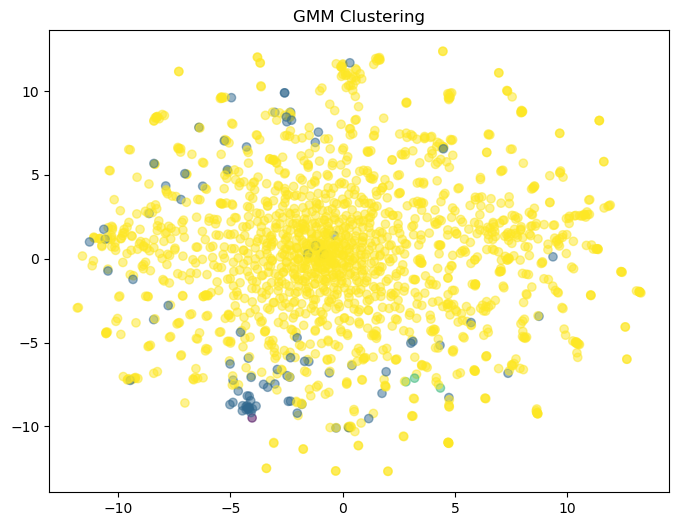

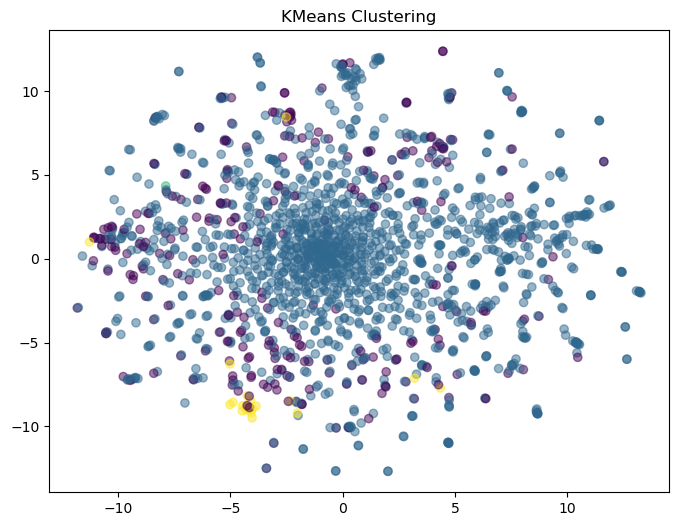

Silhouette Score (KMeans): 0.2805519419224377
Silhouette Score (GMM): 0.4446870990694499


In [309]:
# Assuming X is your data matrix
vectorizer = CountVectorizer(min_df=4,stop_words='english')
X = vectorizer.fit_transform(train_text)

# Evaluate GMM
gmm = GaussianMixture(n_components=4, covariance_type='diag', random_state=42)
silhouette_gmm, _ = evaluate_model(X.toarray(), gmm, 'GMM')

# Evaluate KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
silhouette_kmeans, inertia_kmeans = evaluate_model(X, kmeans, 'KMeans')

# Print results
print(f"Silhouette Score (KMeans): {silhouette_kmeans}")
print(f"Silhouette Score (GMM): {silhouette_gmm}")

In [304]:
def evaluate_model(X, model, name):
    # Fit the model
    model.fit(X)
    
    # Silhouette Score
    if hasattr(model, 'labels_'):  # For models with 'labels_' attribute (e.g., KMeans)
        labels = model.labels_
    else:  # For models without 'labels_' attribute (e.g., GMM)
        labels = model.predict(X)
    
    silhouette = silhouette_score(X, labels)
    
    # Inertia (for KMeans)
    if isinstance(model, KMeans):
        inertia = model.inertia_
    else:
        inertia = None
    
    # Convert sparse matrix to dense for t-SNE
    X_dense = X.toarray() if hasattr(X, 'toarray') else np.array(X)
    
    # Visualize clusters using t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_dense)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.title(f'{name} Clustering')
    plt.show()
    
    return silhouette, inertia

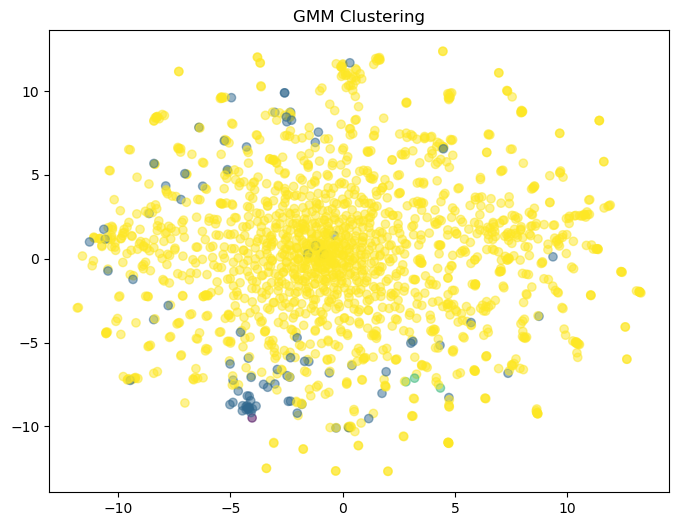

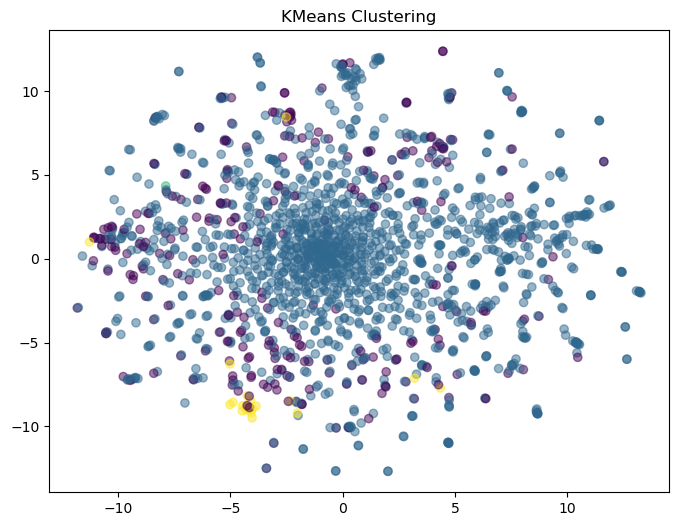

Silhouette Score (KMeans): 0.2805519419224377
Silhouette Score (GMM): 0.4446870990694499


In [311]:
# Assuming X is your data matrix
vectorizer = CountVectorizer(min_df=4,stop_words='english')
X = vectorizer.fit_transform(train_text)

# Evaluate GMM
gmm = GaussianMixture(n_components=4, covariance_type='diag', random_state=42)
silhouette_gmm, _ = evaluate_model(X.toarray(), gmm, 'GMM')

# Evaluate KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
silhouette_kmeans, inertia_kmeans = evaluate_model(X, kmeans, 'KMeans')

# Print results
print(f"Silhouette Score (KMeans): {silhouette_kmeans}")
print(f"Silhouette Score (GMM): {silhouette_gmm}")
#print(f"Silhouette Score (LDA): {lda_silhouette}")